In [1]:
import os, datetime, pathlib, random, glob, cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
import seaborn as sns; sns.set()


from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
from scipy.ndimage import center_of_mass, map_coordinates, geometric_transform

import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
# from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tqdm import tqdm

from utils.importData import importData
from utils.unetModeling import unetModeling
from utils.MCDropout import MCDropout

In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

gpus = tf.config.experimental.list_physical_devices('GPU')
#tf.config.experimental.set_virtual_device_configuration(gpus[1], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=10444)])

In [3]:
now = datetime.datetime.now()

## User defined values put to location of data, 
dataDir = '/home/vagrant/jupyter/StaffScratch/mkilpatr' #default meant to test methods

type = 'topaz' #Select which data to run topaz or hb2a
model = ''
uncertainty = True

In [4]:
if type == 'hb2a':
    files = dataDir + '/data/nuline/hb2a/' # Base directory where all HB2A datafiles (images, masks) are located
    testFile = ''#dataDir + '/data/nuline/hb2a/dataset_13Apr22_noMask' ## leave as empty string if you want to train ML methods
elif type == 'topaz':
    files = dataDir + '/data/nuline/topaz/' # Base directory where all Topaz datafiles (images, masks) are located
    testFile = ''#'BL12_0_864' ## leave as empty string if you want to train ML methods

data = importData(experiment = type, 
                  files = files, 
                  testFile = testFile, 
                  model = model)
data.read()
# data.vizualizeRandomSample()
# data.display(data.x_train, data.y_train)
# data.display(data.x_test, data.y_test)

Loading training data!
Loading testing data!


In [5]:
params = {'explicit': {'nLayers': 5,
                       'batch_size': 128,
                       'learning_rate': 0.001,
                       'nFilters': 16,
                       'dropRate': 0.1},
          # Hyperparameters fromm initial error in model definition
          # 'topaz': {'nLayers': 3,
          #           'nFilters': 8,
          #           'dropRate': 0.17208294383053105,
          #           'batch_size': 128,
          #           'learning_rate': 0.001},
          # 'hb2a': {'nLayers': 5,
          #          'nFilters': 16,
          #          'dropRate': 0.08687520244069533,
          #          'batch_size': 192,
          #          'learning_rate': 0.00027264483568883356}

            # TOPAZ (results/unet_simple_topaz_110322_/trial_177) Score: 0.010489112697541714
            'topaz': {'nLayers': 3, 'nFilters': 16, 'dropRate': 0.05, 'learning_rate': 0.0024749139773314237, 'batch_size': 128},
            # HB2A (results/unet_simple_hb2a_110322/trial_069) Score: 0.018074730411171913
            'hb2a': {'nLayers': 3, 'nFilters': 16, 'dropRate': 0.05, 'learning_rate': 0.0014412219982917283, 'batch_size': 128},
}

params = params['topaz']

nLayers = params['nLayers']
batch_size = params['batch_size']
learning_rate = params['learning_rate']
nFilters = params['nFilters']
dropRate = params['dropRate']

params = "nLayers" + str(nLayers) + "_rate" + str(learning_rate) + "_batchsize" + str(batch_size) + "_nFilters" + str(nFilters) + "_dropRate" + str(dropRate)
saveDir = 'results/plots/MCDropoutUncertainty'
pathlib.Path(saveDir).mkdir(parents=True, exist_ok=True)

In [6]:
epochs=250
patience=int(epochs)

callbacks = [
            tf.keras.callbacks.EarlyStopping(patience=patience, monitor='val_loss', verbose=1),
            ReduceLROnPlateau(factor=0.1, patience=patience, min_lr=0.001, verbose=1)]

newModel = unetModeling(data, 
                        nLayers = nLayers, 
                        batch_size = batch_size, 
                        learning_rate = learning_rate, 
                        nFilters = nFilters, 
                        dropRate = dropRate, 
                        epochs=epochs,
                        callbacks = callbacks if uncertainty else None)

newModel.unetCustom(nFilters = newModel.nFilters, 
                    nLayers = newModel.nLayers, 
                    dropRate = newModel.dropRate)
#newModel.createModel(saveDir = saveDir, isCustom = True)
newModel.model.load_weights('/home/vagrant/jupyter/StaffScratch/mkilpatr/nuline/nuline/standalone/results/plots/MCDropoutUncertainty/model_topaz_2023_01_19_19-48-27/model_topaz.h5')

2023-01-20 05:21:23.503152: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-20 05:21:24.140811: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30519 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:af:00.0, compute capability: 7.0


Uncertainty from Convex on Sample 0: [10.62652269  6.02950717]
Uncertainty from Convex on Sample 1: [10.66000914  5.88665592]
Uncertainty from Convex on Sample 2: [10.59178464  9.86556156]
Uncertainty from Convex on Sample 3: [9.17423301 4.0696796 ]


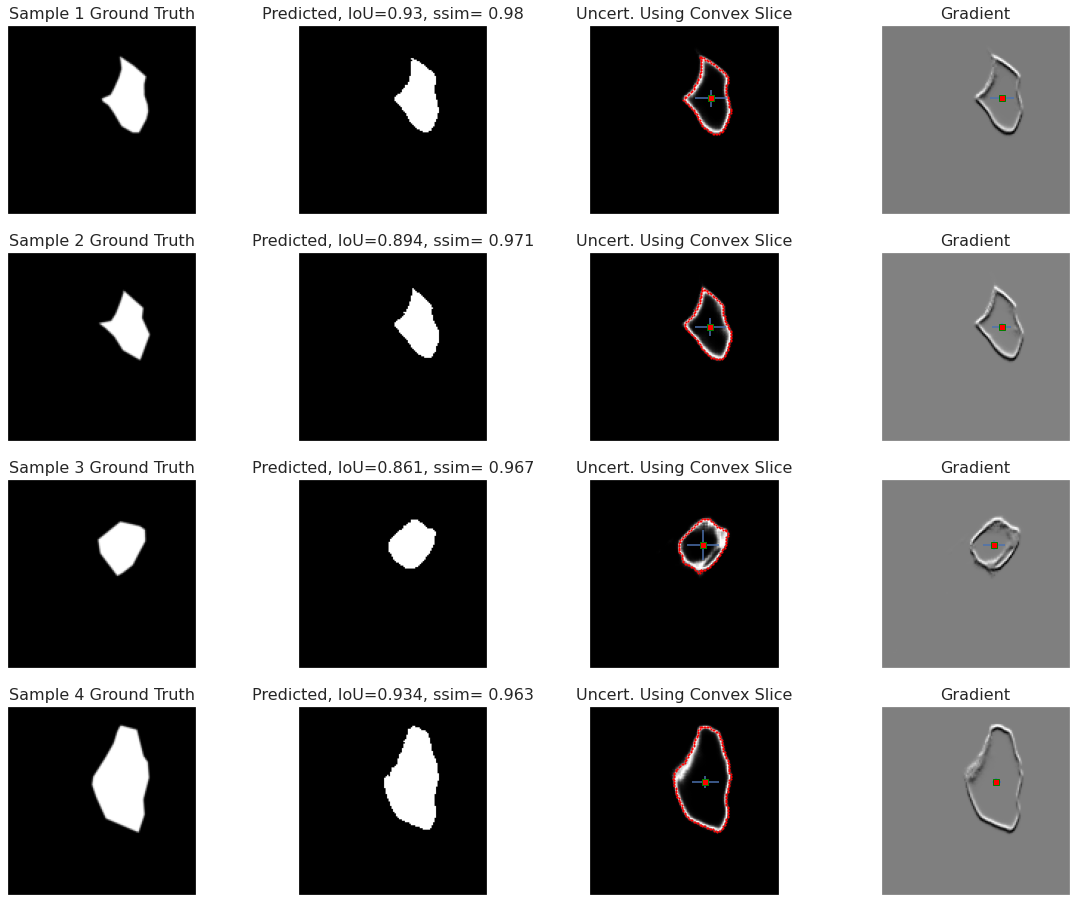

In [12]:
if uncertainty:
    mcdrop = MCDropout(newModel.model, 
                       data, 
                       nPredict = 20, 
                       saveDir = saveDir)
    mcdrop.getUncertainty(4)
    

In [8]:
Ntest = 30
data_ = data.x_test
predict = np.empty(shape = (Ntest, data_.shape[0], 128, 128, 1))
for t in range(Ntest):#already did one above
    predict[t] = mcdrop.model.predict(data_,batch_size=1)

In [9]:
def calcEntropy(Y_ts_hat):
    # Calculation pixel error using entropy

    
    P_foreground = Y_ts_hat
    P_background = 1.0-P_foreground

    U_ts = -(P_foreground*np.log(P_foreground)+P_background*np.log(P_background))

    U_ts_foreground=-(P_foreground*np.log(P_foreground))

    U_ts_background=-(P_background*np.log(P_background))
    np.nan_to_num(U_ts_background, copy=False)

    #%% convert predicted mask to binary
    Y_ts_hat= (Y_ts_hat > 0.5).astype(np.float32)

    # threshold=0.5
    # Y_ts_hat[Y_ts_hat<threshold]=0
    # Y_ts_hat[Y_ts_hat>=threshold]=1
    return Y_ts_hat, U_ts_background, U_ts_foreground, U_ts, np.log(P_foreground), np.log(P_background)

y_ts_hat, U_ts_background, U_ts_foreground, U_ts, U_ts_foreground_log, U_ts_background_log = calcEntropy(np.sum(predict, axis = 0))

/home/vagrant/.pyenv/versions/py3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  
/home/vagrant/.pyenv/versions/py3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in multiply
  
/home/vagrant/.pyenv/versions/py3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log
  
/home/vagrant/.pyenv/versions/py3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/home/vagrant/.pyenv/versions/py3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in multiply
  # Remove the CWD from sys.path while we load stuff.
/home/vagrant/.pyenv/versions/py3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in log
  if sys.path[0] == '':
/home/vagrant/.pyenv/version

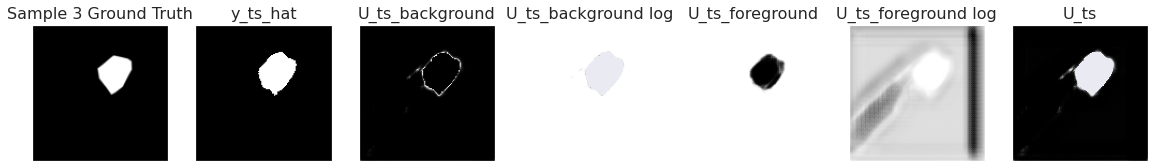

In [10]:
fig, axes = plt.subplots(1, 7,figsize=(20,Ntest*4))
step=0.01
i = 2
s=0
im=axes[s].imshow(data.y_test[i,:,:,0], cmap='gray')
axes[s].set_xticks([])
axes[s].set_yticks([])
title = 'Sample ' + str(i + 1) + ' Ground Truth'
axes[s].set_title(title,{'fontsize':16})

s=1
y, x = center_of_mass(y_ts_hat[i,:,:,0])
im=axes[s].imshow(y_ts_hat[i,:,:,0], cmap='gray')
axes[s].set_xticks([])
axes[s].set_yticks([])
axes[s].set_title('y_ts_hat',{'fontsize':16})

s=2
im=axes[s].imshow(U_ts_background[i,:,:,0], cmap='gray')
axes[s].set_xticks([])
axes[s].set_yticks([])
axes[s].set_title('U_ts_background',{'fontsize':16})

s=3
im=axes[s].imshow(U_ts_background_log[i,:,:,0], cmap='gray')
axes[s].set_xticks([])
axes[s].set_yticks([])
axes[s].set_title('U_ts_background log',{'fontsize':16})

s=4
im=axes[s].imshow(U_ts_foreground[i,:,:,0], cmap='gray')
axes[s].set_xticks([])
axes[s].set_yticks([])
axes[s].set_title('U_ts_foreground',{'fontsize':16})

s=5
im=axes[s].imshow(U_ts_foreground_log[i,:,:,0], cmap='gray')
axes[s].set_xticks([])
axes[s].set_yticks([])
axes[s].set_title('U_ts_foreground log',{'fontsize':16})

s=6
im=axes[s].imshow(U_ts[i,:,:,0], cmap='gray')
axes[s].set_xticks([])
axes[s].set_yticks([])
axes[s].set_title('U_ts',{'fontsize':16})

fig.savefig(os.path.join(saveDir, 'UQ_methods.png'))
fig.show()